In [1]:
# join back online

In [2]:
from fastai.vision import *

In [3]:
import warnings
import matplotlib.pyplot as plt

In [4]:
warnings.filterwarnings("ignore")

### Data

In [5]:
path = Path('dataset')

In [6]:
np.random.seed(41)
data = ImageDataBunch.from_folder(path, train="Train", valid ="Valid",ds_tfms=get_transforms(), size=(256,256), bs=32, num_workers=4).normalize()

In [7]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Covid-19', 'Pneumonia', 'normal'], 3, 900, 225)

In [8]:
print("Number of examples in training:", len(data.train_ds))
print("Number of examples in validation:", len(data.valid_ds))

Number of examples in training: 900
Number of examples in validation: 225


In [9]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

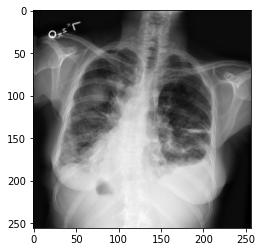

In [10]:
plt.imshow(xb[0][0],cmap='gray')

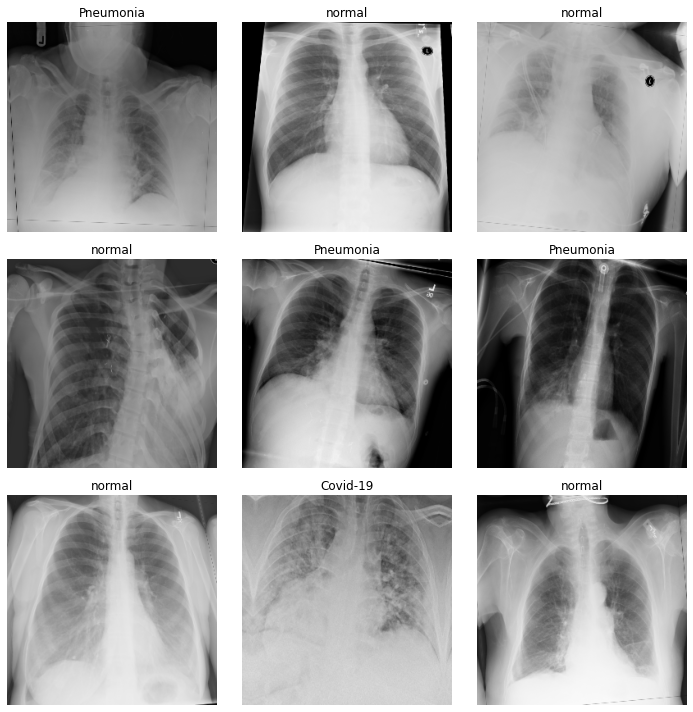

In [11]:
data.show_batch(rows=3, figsize=(10,10))

## DarkCovidNet (modified Darknet model)

In [12]:
def conv_block(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False), 
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True))

In [13]:
def triple_conv(ni, nf):
    return nn.Sequential(
        conv_block(ni, nf),
        conv_block(nf, ni, size=1),  
        conv_block(ni, nf)
    )

In [14]:
def maxpooling():
    return nn.MaxPool2d(2, stride=2)

In [15]:
model = nn.Sequential(
    conv_block(3, 8),
    maxpooling(),
    conv_block(8, 16),
    maxpooling(),
    triple_conv(16, 32),
    maxpooling(),
    triple_conv(32, 64),
    maxpooling(),
    triple_conv(64, 128),
    maxpooling(),
    triple_conv(128, 256),
    conv_block(256, 128, size=1),
    conv_block(128, 256),
    conv_layer(256, 3),
    Flatten(),
    nn.Linear(507, 3)
)

In [16]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [17]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 256, 256]        216        True      
______________________________________________________________________
BatchNorm2d          [8, 256, 256]        16         True      
______________________________________________________________________
LeakyReLU            [8, 256, 256]        0          False     
______________________________________________________________________
MaxPool2d            [8, 128, 128]        0          False     
______________________________________________________________________
Conv2d               [16, 128, 128]       1,152      True      
______________________________________________________________________
BatchNorm2d          [16, 128, 128]       32         True      
______________________________________________________________________
LeakyReLU            [16, 128, 128]       0          False     
___________________________________________________

In [18]:
learn.fit_one_cycle(100, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.880502,1.098691,0.444444,03:46
1,0.773596,0.557989,0.800000,03:44
2,0.697855,0.554901,0.782222,03:36
3,0.634044,0.616385,0.760000,03:28
4,0.622118,0.891919,0.733333,03:27
5,0.612586,0.488167,0.808889,03:35
6,0.576612,0.546766,0.791111,03:35
7,0.572592,0.590207,0.733333,03:29
8,0.558753,1.013241,0.648889,03:19
9,0.547217,0.781782,0.742222,03:20


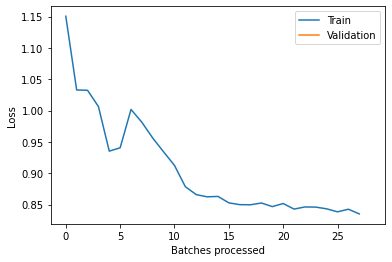

In [89]:
learn.recorder.plot_losses()

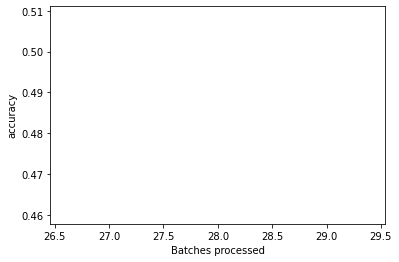

In [90]:
learn.recorder.plot_metrics()

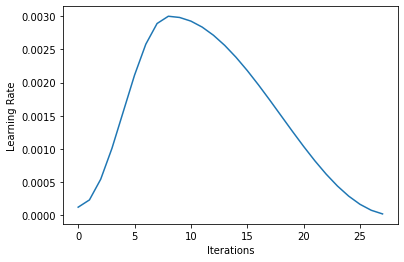

In [91]:
learn.recorder.plot_lr()

In [92]:
print("Number of examples in testing:", len(data.valid_ds))

Number of examples in testing: 225


In [93]:
probs,targets = learn.get_preds(ds_type=DatasetType.Valid) # Predicting without TTA

In [94]:
accuracy(probs,targets)

tensor(0.4844)

In [95]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Covid-19', 'Pneumonia', 'normal'], 3, 900, 225)

In [96]:
probs = np.argmax(probs, axis=1)
correct = 0
for idx, pred in enumerate(probs):
    if pred == targets[idx]:
        correct += 1
accuracy = correct / len(probs)
print(len(probs), correct, accuracy)

from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=np.inf) # shows whole confusion matrix
cm1 = confusion_matrix(targets, probs)
print(cm1)

from sklearn.metrics import classification_report
y_true1 = targets
y_pred1 = probs
target_names = ['Covid-19', 'No_findings', 'Pneumonia']
print(classification_report(y_true1, y_pred1, target_names=target_names))

225 109 0.48444444444444446
[[11  0 14]
 [13  0 87]
 [ 2  0 98]]
              precision    recall  f1-score   support

    Covid-19       0.42      0.44      0.43        25
 No_findings       0.00      0.00      0.00       100
   Pneumonia       0.49      0.98      0.66       100

    accuracy                           0.48       225
   macro avg       0.31      0.47      0.36       225
weighted avg       0.27      0.48      0.34       225



In [97]:
interp = ClassificationInterpretation.from_learner(learn)

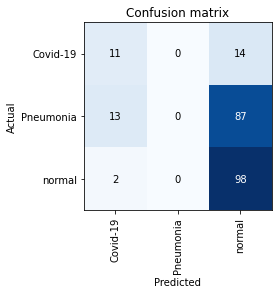

In [98]:
cm_fig = interp.plot_confusion_matrix(return_fig=True)
ax = cm_fig.gca()
ax.set_ylim(interp.data.c - .5, - .5);

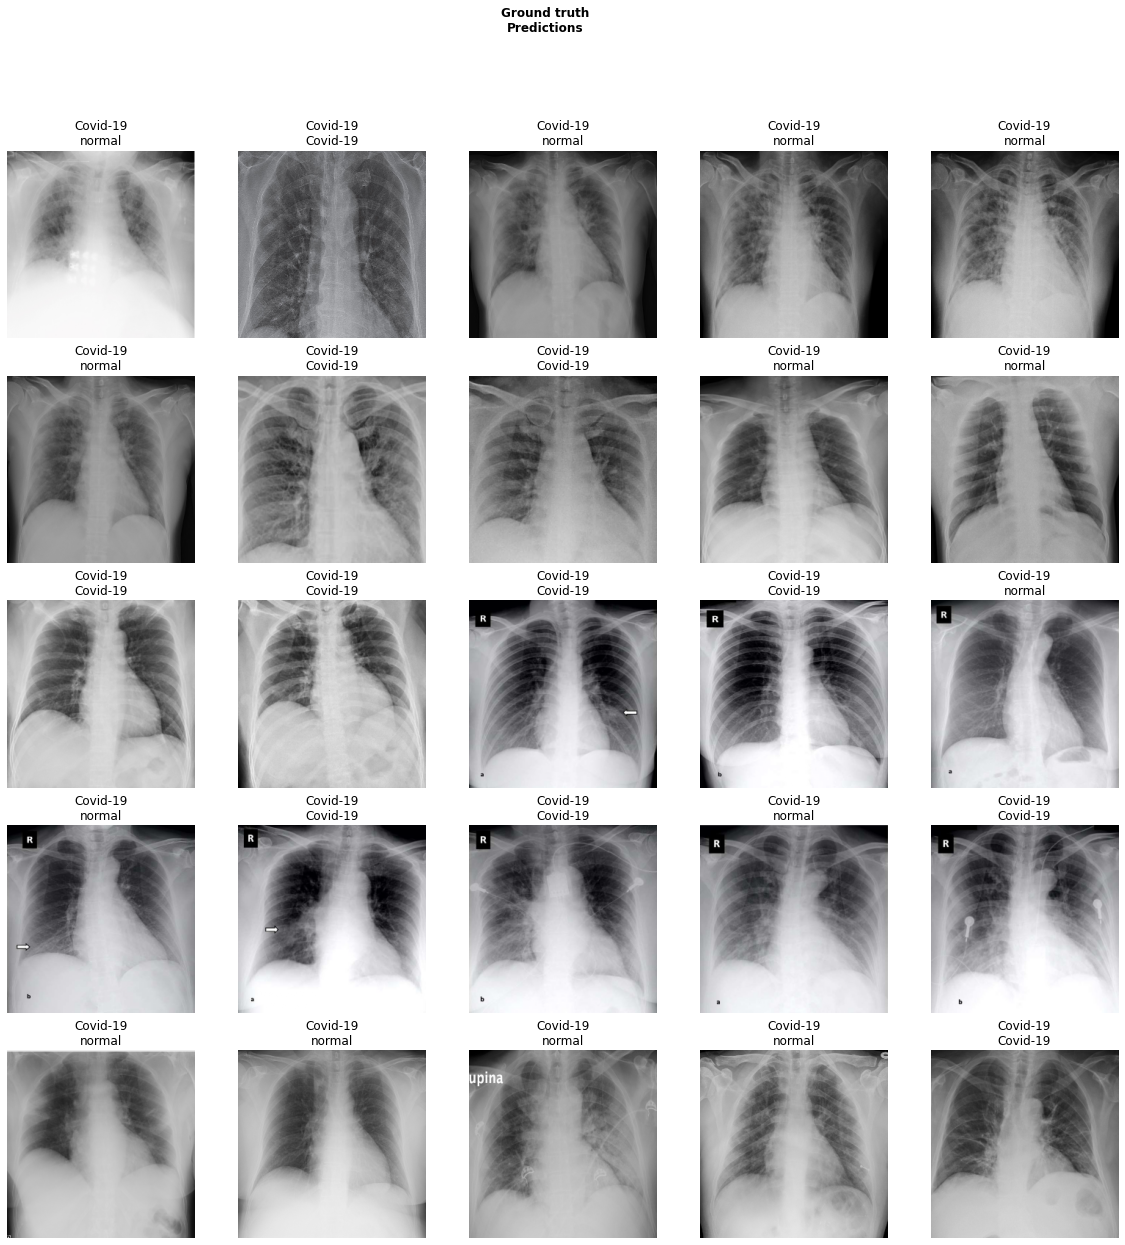

In [99]:
learn.show_results(max_n=16)

In [100]:
# learn.save('covid_classifier_model',return_path=True)

In [101]:
learn.export('model.pkl')
print('done')

done


In [102]:
# simple test

In [103]:
learner = load_learner(path='covid_classifier_model',file='model.pkl')

In [105]:
img = open_image(r"D:\Documents\New folder\Covid-19 Detection using chest x-ray\CORONA.jpg")

In [106]:
cat,tensor,probs=learner.predict(img)
print(cat)

Covid-19
